In [3]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [6]:
from scipy.stats import norm
from scipy.integrate import quad
from scipy.stats import gamma as gamma_pdf
from scipy.stats import norm

from jax.scipy.special import gamma, gammaincc
from jax.scipy.integrate import trapezoid

In [10]:
import sys
sys.path.insert(0, '/home/storage/hans/jax_reco_new/')
from lib.plotting import adjust_plot_1d

In [52]:
@jax.jit
def biweight_gamma_prob(x, a, b, s):  
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)

    gincc_a_m = gammaincc(a, b*(x-s)) * g_a
    gincc_1pa_m = gammaincc(1+a, b*(x-s))*gamma(1+a)
    gincc_2pa_m = gammaincc(2+a, b*(x-s))*gamma(2+a)
    gincc_3pa_m = gammaincc(3+a, b*(x-s))*gamma(3+a)
    gincc_4pa_m = gammaincc(4+a, b*(x-s))*gamma(4+a)

    # branch 0 (-s < t < +s)
    tsum0 = (
                (g_a - gincc_a) * b**4 * (s**4 - 2*s**2*x**2 + x**4)
                + (g_1pa - gincc_1pa) * b**3 * (4*s**2*x - 4*x**3)
                + (g_2pa - gincc_2pa) * (b**2*(6*x**2 - 2*s**2))
                - g_2pa * (8*b*x + 4*a*b*x)
                + g_4pa - gincc_4pa
                + gincc_3pa * 4*b*x
    )
    
    # branch 1 ( t >= +s)
    tsum1 = (
                (gincc_a_m - gincc_a) * (b**4*s**4 - 2*b**4*s**2*x**2 + b**4*x**4)
                + (gincc_1pa_m - gincc_1pa) * (4*b**3*s**2*x - 4*b**3*x**3)
                + (gincc_2pa- gincc_2pa_m) * (2*b**2*s**2 - 6*b**2*x**2)
                + (gincc_3pa - gincc_3pa_m) * (4*b*x)
                + gincc_4pa_m - gincc_4pa         
    )

    # combined branches
    tsum = jnp.where(x < s, tsum0, tsum1)
    # set to 0 outside of support
    #tsum = jnp.where(x < -s, 0.0, tsum)
    
    pre_fac = 15.0/(16*b**4*s**5*g_a)
    return pre_fac * tsum

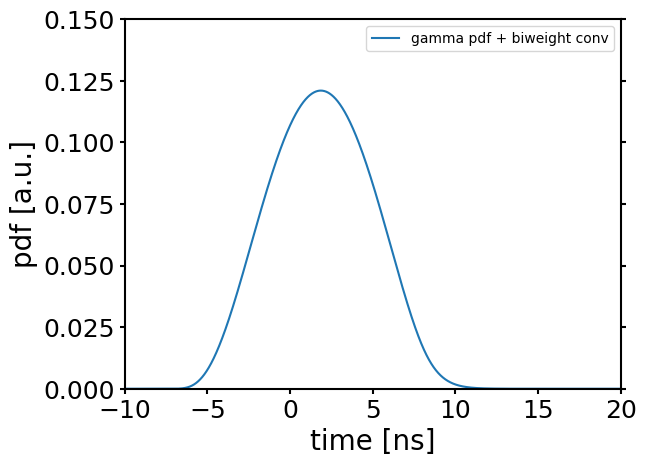

In [53]:
a = 3.75
b = 2.0
sigma = 3.0

xvals = np.linspace(-10, 30, 10000)
yvals_biweight_conv_gamma = biweight_gamma_prob(xvals, a, b, 2.5*sigma)
fig, ax = plt.subplots()

ax.plot(xvals, yvals_biweight_conv_gamma, label='gamma pdf + biweight conv')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 20], 
                 'ylim':[0.0, 0.15]}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.show()

In [54]:
def biweight_gamma_cdf_numeric(x, a, b, s):
    xvals = np.linspace(-s, x, 10000)
    yvals = biweight_gamma(xvals, a, b, s)
    return trapezoid(yvals, x=xvals)

In [65]:
print(biweight_gamma_cdf_numeric(12.0, a, b, 2.5*sigma))

0.9999412190942546


In [56]:
@jax.jit
def biweight_gamma_cdf(x, a, b, s):  
    g_a = gamma(a)
    bspx = b * (s+x)
    g_a_bspx = g_a * gammaincc(a, bspx)
    bxms = b * (x-s)
    g_a_btms = g_a * gammaincc(a, bxms)

    # branch 0 x < s
    pre_factor = 1./(16.*b**5*s**5*(s+x)*g_a) * jnp.exp(-bspx)

    c__51 = (-1 + a)*(16 + 7*a)*s**2 + 3*(3 + a)*(2 + 3*a)*s*x - 6*(1 + 3*a*(2 + a))*x**2
    c__52 = (8 + 7*a)*s**2 - 3*(3 + 7*a)*s*x + 3*(1 + 4*a)*x**2
    c__53 = (4 + a)*s - (1 + 4*a)*x
    c__54 = 8*s**5 + 15*s**4*x - 10*s**2*x**3
    
    c__5 = (
        3*(1 + a)*(2 + a)*(3 + a)*(4 + a)*x 
        + 3*(2 + a)*(3 + a)*bspx * c__53 
        - b**3*(s + x)**2 * c__52 - b**2*(s + x) * c__51 + b**4 * c__54
    )
    
    c__611 = (
        3*b**3*s**4 - 18*x 
        + 3*b*x**2*(4 + b*x*(-2 + b*x)) 
        + b*s**2*(-4 - 6*b*x*(-1 + b*x))
    )
    c__61 = (-72 - 5*b * c__611)
    c__62 = (-11*x + 2*b*(x**2*(3 - b*x) + s**2*(-1 + b*x)))
    
    c__6 = (
        -3*a**5 + 15*a**4*(-2 + b*x)
        + b**5*(s + x)**3*(8*s**2 - 9*s*x + 3*x**2) 
        + 5*a**3*(-21 + 2*b*(9*x + b*(s**2 - 3*x**2))) 
        - 15*a**2*(10 + b * c__62) + a * c__61
    )
                             
    tsum = (
        3*b**(4 + a)*x**5*(s + x)**a 
        + 3*(1 + a)*(2 + a)*(3 + a)*(4 + a)* s*(bspx)**a 
            + (bspx)**a * c__5
            + jnp.exp(bspx)*(s + x) * c__6 * (g_a - g_a_bspx)
    )

    return pre_factor * tsum

In [60]:
%timeit biweight_gamma_cdf(6.0, 3.75, 2.0, 2.5*3.0).block_until_ready()

293 μs ± 3.84 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [61]:
biweight_gamma_cdf(6.0, 3.75, 2.0, 2.5*3.0)

Array(0.90978459, dtype=float64, weak_type=True)

In [62]:
%timeit biweight_gamma_prob(jnp.array(6.0), jnp.array(3.75), jnp.array(2.0), jnp.array(2.5*3.0)).block_until_ready()

1.74 ms ± 1.09 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
def biweight_gamma2_p2:
1 - (1/(16*b^5*s^5*
       Gamma[a]))*((b^
         a*(3*(1 + a)*(2 + a)*(3 + a)*(4 + 
             a)*(E^(2*b*s)*(-s + t)^a - (s + t)^a) + 
          3*(2 + a)*(3 + a)*
           b*((s + t)^a*(-((4 + a)*s) + t + 4*a*t) - 
             E^(2*b*s)*(-s + t)^a*((4 + a)*s + t + 4*a*t)) + 
          b^4*((s + t)^(2 + a)*(-8*s^2 + 9*s*t - 3*t^2) + 
             E^(2*b*s)*(-s + t)^(2 + a)*(8*s^2 + 9*s*t + 3*t^2)) + 
          b^3*((s + t)^(1 + a)*((8 + 7*a)*s^2 - 3*(3 + 7*a)*s*t + 
                3*(1 + 4*a)*t^2) - 
             E^(2*b*s)*(-s + t)^(1 + a)*((8 + 7*a)*s^2 + 
                3*(3 + 7*a)*s*t + 3*(1 + 4*a)*t^2)) + 
          b^2*((s + t)^
               a*((-1 + a)*(16 + 7*a)*s^2 + 3*(3 + a)*(2 + 3*a)*s*t - 
                6*(1 + 3*a*(2 + a))*t^2) + 
             E^(2*b*s)*(-s + t)^
               a*(-((-1 + a)*(16 + 7*a)*s^2) + 
                3*(3 + a)*(2 + 3*a)*s*t + 6*(1 + 3*a*(2 + a))*t^2))) +
        E^(b*(s + t))*((3*a^5 - 15*a^4*(-2 + b*t) + 
             b^5*(s - t)^3*(8*s^2 + 9*s*t + 3*t^2) + 
             5*a^3*(21 - 2*b*(9*t + b*(s^2 - 3*t^2))) + 
             15*a^2*(10 + 
                b*(-11*t + 2*b*(t^2*(3 - b*t) + s^2*(-1 + b*t)))) + 
             a*(72 + 5*
                 b*(3*b^3*s^4 - 18*t + 3*b*t^2*(4 + b*t*(-2 + b*t)) + 
                   b*s^2*(-4 - 6*b*t*(-1 + b*t)))))*
           Gamma[a, 
            b*(-s + t)] + (-3*a^5 + 15*a^4*(-2 + b*t) + 
             b^5*(s + t)^3*(8*s^2 - 9*s*t + 3*t^2) + 
             5*a^3*(-21 + 2*b*(9*t + b*(s^2 - 3*t^2))) - 
             15*a^2*(10 + 
                b*(-11*t + 2*b*(t^2*(3 - b*t) + s^2*(-1 + b*t)))) + 
             a*(-72 + 90*b*t - 
                5*b^2*(3*b^2*s^4 + 3*t^2*(4 + b*t*(-2 + b*t)) + 
                   s^2*(-4 - 6*b*t*(-1 + b*t)))))*
           Gamma[a, b*(s + t)]))/E^(b*(s + t)))]